# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ctypes import *
import os
import platform

In [2]:
#Function of conversion of list of list to simple list 
def toList(arr):
    return [j for i in arr for j in i]

In [3]:
#
path_to_shared_library = "target/debug/librust_lib.dylib"
path_to_shared_library_windows = "target\\debug\\rust_lib.dll"

if(platform.system()=='Windows'):
    my_lib = cdll.LoadLibrary(path_to_shared_library_windows)
else : 
    my_lib = cdll.LoadLibrary(path_to_shared_library)


# Cas de tests, rendu 2

## Classification

### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK

#### Linear Model : 

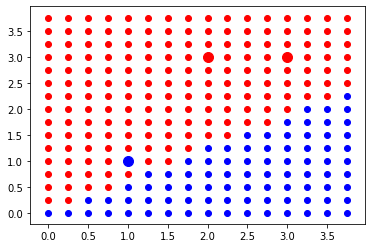

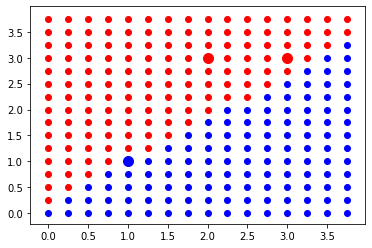

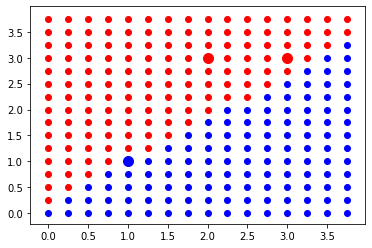

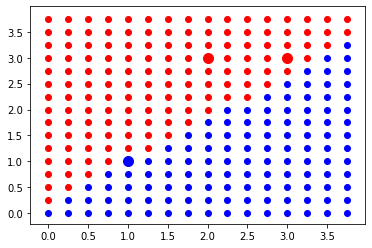

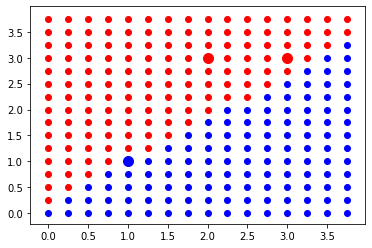

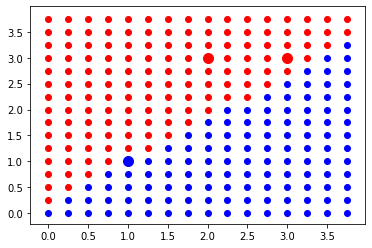

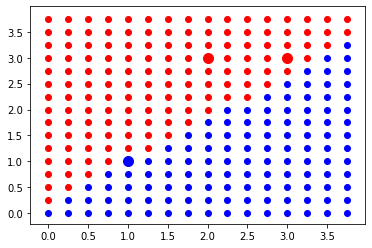

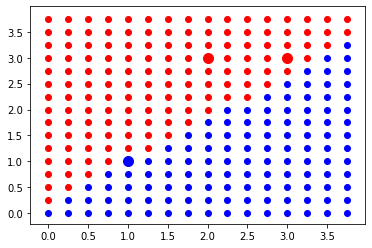

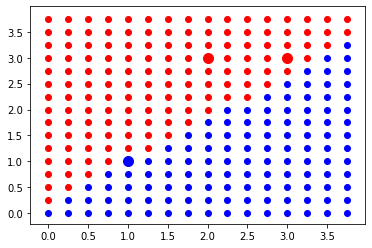

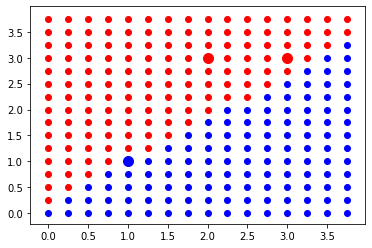

<Figure size 432x288 with 0 Axes>

In [11]:
#Dataset
X= np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y= np.array([
      1,
      -1,
      -1
])


#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y.tolist()
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs )


#Declaration of argtypes and restypes for the function create_model
my_lib.create_model.argtypes = [c_int]
my_lib.create_model.restype = POINTER(c_float)

#Creation of model
arr_size = 3
native_arr = my_lib.create_model(arr_size)


#Declaration of argtypes and restypes for the function train_rosenblatt_linear_model
arr_type = type(native_arr)
inputs_type = c_float * inputs_len
outputs_type = c_float * expected_len
my_lib.train_rosenblatt_linear_model.argtypes = [arr_type, inputs_type, outputs_type, c_int, c_float, c_int, c_int,c_int]
my_lib.train_rosenblatt_linear_model.restype = None
inputs_native = inputs_type(*dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

#Declaration of argtypes and restypes for the function predict_linear_model_classification
coordonate_type = c_float * 2
my_lib.predict_linear_model_classification.argtypes = [arr_type, coordonate_type, c_int,c_int]
my_lib.predict_linear_model_classification.restype = c_float


#Trainning
r = np.arange(0.0, 4.0, 0.25)

for _ in range(100):
    points_x1_blue = []
    points_x2_blue = []

    points_x1_red = []
    points_x2_red = []

    for i in r:
        for j in r:
            coord = coordonate_type(*[i, j])
            res=my_lib.predict_linear_model_classification(native_arr, coord,arr_size,inputs_len)
            if  res> 0.0:
                points_x1_blue.append(i)
                points_x2_blue.append(j)
            else:
                points_x1_red.append(i)
                points_x2_red.append(j)

    
    if(_%10==0):
        plt.scatter(points_x1_blue, points_x2_blue, c='blue')
        plt.scatter(points_x1_red, points_x2_red, c='red')
        
        plt.scatter([X[p][0] for p in range(len(Y)) if Y[p]>0], [X[p][1] for p in range(len(Y)) if Y[p]>0], c='blue', s=100)
        plt.scatter([X[p][0] for p in range(len(Y)) if Y[p]<0], [X[p][1] for p in range(len(Y)) if Y[p]<0], c='red', s=100)

        plt.show()
        plt.clf()

    dataset_inputs_for_train = []
    for elt in X:
        dataset_inputs_for_train.append(elt[0])
        dataset_inputs_for_train.append(elt[1])

    #update model
    my_lib.train_rosenblatt_linear_model(native_arr, inputs_native, outputs_native, 20, 0.001, arr_size, inputs_len,expected_len)    
    np_arr = np.ctypeslib.as_array(native_arr, (arr_size,))

#Free memory
my_lib.destroy_array.argtypes = [POINTER(c_float), c_int]
my_lib.destroy_array.restype = None
my_lib.destroy_array(native_arr, arr_size)


### MLP

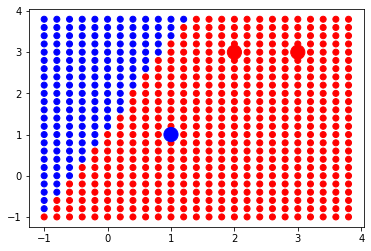

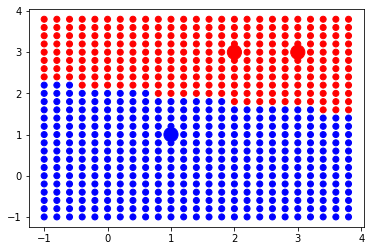

In [4]:
#Dataset
X= np.array([
      [1, 1],
      [2, 3],
      [3, 3]
])
Y= np.array([
      1,
      -1,
      -1
])

d=[2,1]

#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y.tolist()
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)


#Declaration of argtypes and restypes for the function create_mlp_model
arr_size = len(d)
arr_type = c_int * arr_size
native_arr = arr_type(*d)
my_lib.create_mlp_model.argtypes = [arr_type, c_int]
my_lib.create_mlp_model.restype = c_void_p


model = my_lib.create_mlp_model(native_arr,2)
test_dataset = [[x1/10, x2 / 10] for x1 in range(-10, 40,2) for x2 in range(-10, 40,2)]
colors = ["blue" if output >= 0 else "red" for output in dataset_expected_outputs]


#Declaration of argtypes and restypes for the function predict_mlp_model_classification
p_type = c_float*2
my_lib.predict_mlp_model_classification.argtypes = [c_void_p, p_type,c_int]
my_lib.predict_mlp_model_classification.restype = POINTER(c_float)
p_len =2

predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])


flattened_len=len(flattened_dataset_inputs )
#Declaration of argtypes and restypes for the function predict_mlp_model_classification
inputs_type = c_float * flattened_len
outputs_type = c_float * expected_len
my_lib.train_classification_stochastic_backdrop_mlp_model.argtypes = [c_void_p,inputs_type,outputs_type,c_float,c_int,c_int,c_int]
my_lib.train_classification_stochastic_backdrop_mlp_model.restype = None
inputs_native = inputs_type(*flattened_dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

my_lib.train_classification_stochastic_backdrop_mlp_model(model,inputs_native,outputs_native,0.001,100000,flattened_len,expected_len)


predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])

#Free memory
my_lib.destroy_model.argtypes = [c_void_p]
my_lib.destroy_model.restype = None
my_lib.destroy_model(model)


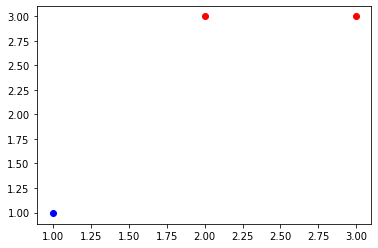

<Figure size 432x288 with 0 Axes>

In [42]:
plt.scatter(X[0, 0], X[0, 1], color='blue')
plt.scatter(X[1:3,0], X[1:3,1], color='red')
plt.show()
plt.clf()

### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

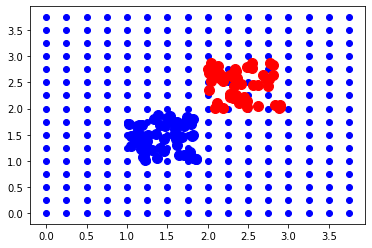

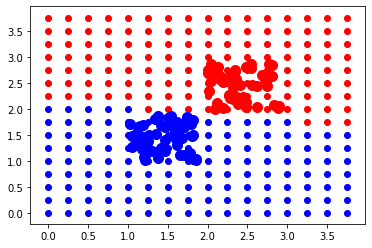

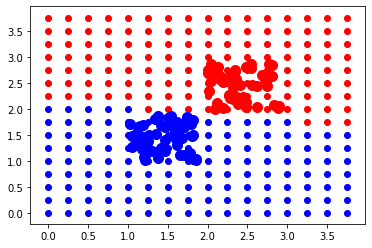

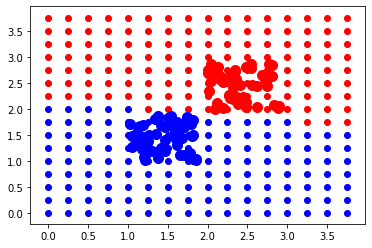

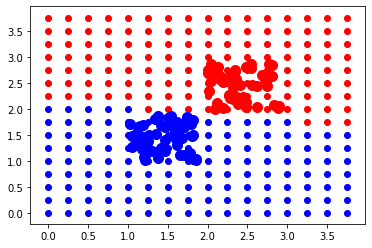

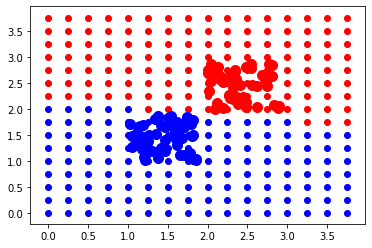

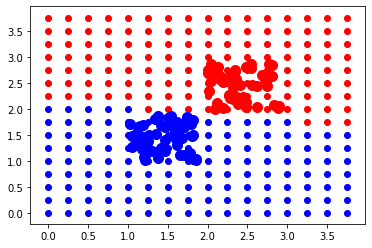

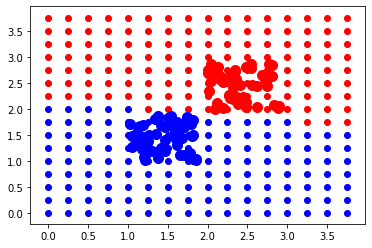

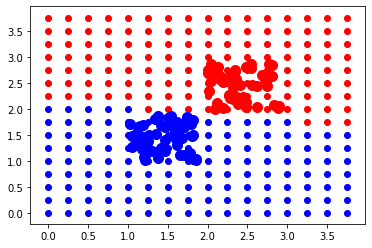

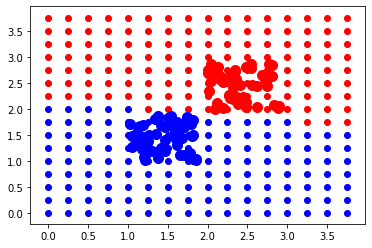

<Figure size 432x288 with 0 Axes>

In [39]:
#Dataset
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])


#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs )


#Declaration of argtypes and restypes for the function create_model
my_lib.create_model.argtypes = [c_int]
my_lib.create_model.restype = POINTER(c_float)

#Creation of model
arr_size = 3
native_arr = my_lib.create_model(arr_size)

#Declaration of argtypes and restypes for the function train_rosenblatt_linear_model
arr_type = type(native_arr)
inputs_type = c_float * inputs_len
outputs_type = c_float * expected_len
my_lib.train_rosenblatt_linear_model.argtypes = [arr_type, inputs_type, outputs_type, c_int, c_float, c_int, c_int,c_int]
my_lib.train_rosenblatt_linear_model.restype = None
inputs_native = inputs_type(*dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

#Declaration of argtypes and restypes for the function predict_linear_model_classification
coordonate_type = c_float * 2
my_lib.predict_linear_model_classification.argtypes = [arr_type, coordonate_type, c_int,c_int]
my_lib.predict_linear_model_classification.restype = c_float


#Trainning
r = np.arange(0.0, 4.0, 0.25)

for _ in range(100):
    points_x1_blue = []
    points_x2_blue = []

    points_x1_red = []
    points_x2_red = []

    for i in r:
        for j in r:
            coord = coordonate_type(*[i, j])
            res=my_lib.predict_linear_model_classification(native_arr, coord,arr_size,inputs_len)
            if  res> 0.0:
                points_x1_blue.append(i)
                points_x2_blue.append(j)
            else:
                points_x1_red.append(i)
                points_x2_red.append(j)

    if(_%10==0):        
        plt.scatter(points_x1_blue, points_x2_blue, c='blue')
        plt.scatter(points_x1_red, points_x2_red, c='red')

        plt.scatter([X[p][0] for p in range(len(Y)) if Y[p]>0], [X[p][1] for p in range(len(Y)) if Y[p]>0], c='blue', s=100)
        plt.scatter([X[p][0] for p in range(len(Y)) if Y[p]<0], [X[p][1] for p in range(len(Y)) if Y[p]<0], c='red', s=100)

        plt.show()
        plt.clf()

    dataset_inputs_for_train = []
    for elt in X:
        dataset_inputs_for_train.append(elt[0])
        dataset_inputs_for_train.append(elt[1])

    #update model
    my_lib.train_rosenblatt_linear_model(native_arr, inputs_native, outputs_native, 50, 0.001, arr_size, inputs_len,expected_len)    
    np_arr = np.ctypeslib.as_array(native_arr, (arr_size,))

    
#Free memory
my_lib.destroy_array.argtypes = [POINTER(c_float), c_int]
my_lib.destroy_array.restype = None
my_lib.destroy_array(native_arr, arr_size)




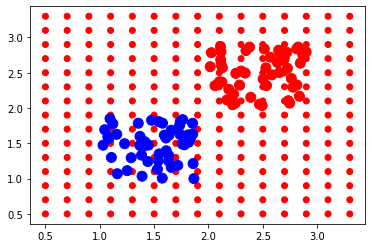

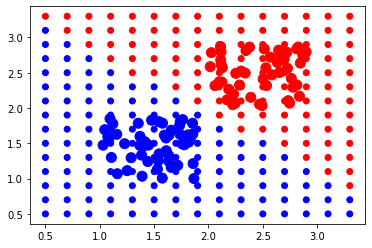

In [5]:
#Dataset
X = np.concatenate([np.random.random((50,2)) * 0.9 + np.array([1, 1]), np.random.random((50,2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

d=[2,1]

#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)


#Declaration of argtypes and restypes for the function create_mlp_model
arr_size = len(d)
arr_type = c_int * arr_size
native_arr = arr_type(*d)
my_lib.create_mlp_model.argtypes = [arr_type, c_int]
my_lib.create_mlp_model.restype = c_void_p


model = my_lib.create_mlp_model(native_arr,2)
test_dataset = [[x1/10, x2 / 10] for x1 in range(5, 35,2) for x2 in range(5, 35,2)]
colors = ["blue" if output >= 0 else "red" for output in dataset_expected_outputs]


#Declaration of argtypes and restypes for the function predict_mlp_model_classification
p_type = c_float*2
my_lib.predict_mlp_model_classification.argtypes = [c_void_p, p_type,c_int]
my_lib.predict_mlp_model_classification.restype = POINTER(c_float)
p_len =2

predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])


flattened_len=len(flattened_dataset_inputs )
#Declaration of argtypes and restypes for the function predict_mlp_model_classification
inputs_type = c_float * flattened_len
outputs_type = c_float * expected_len
my_lib.train_classification_stochastic_backdrop_mlp_model.argtypes = [c_void_p,inputs_type,outputs_type,c_float,c_int,c_int,c_int]
my_lib.train_classification_stochastic_backdrop_mlp_model.restype = None
inputs_native = inputs_type(*flattened_dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

my_lib.train_classification_stochastic_backdrop_mlp_model(model,inputs_native,outputs_native,0.001,100000,flattened_len,expected_len)


predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])

    #Free memory
my_lib.destroy_model.argtypes = [c_void_p]
my_lib.destroy_model.restype = None
my_lib.destroy_model(model)

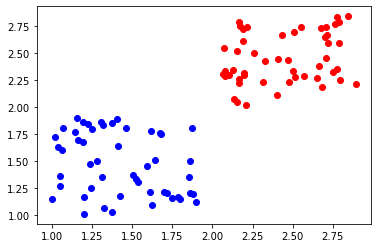

<Figure size 432x288 with 0 Axes>

In [30]:
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue')
plt.scatter(X[50:100,0], X[50:100,1], color='red')
plt.show()
plt.clf()

### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK
        
        Gaussienne : ?

In [ ]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

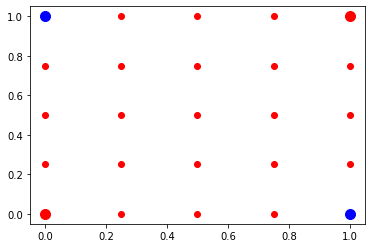

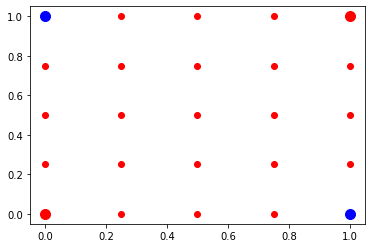

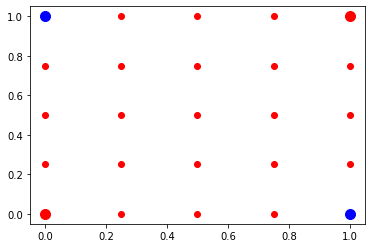

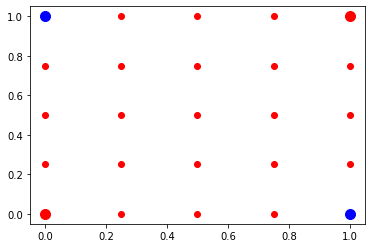

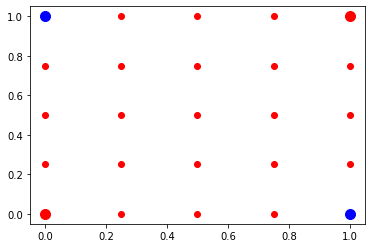

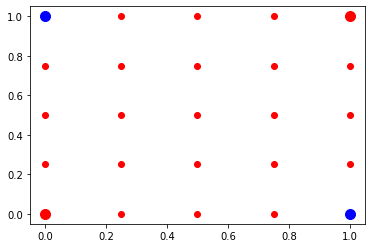

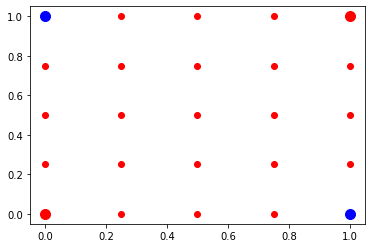

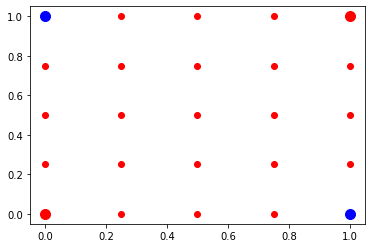

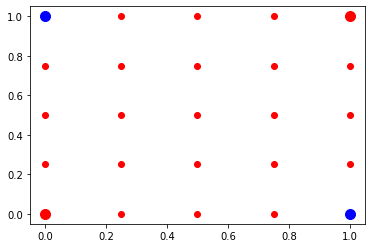

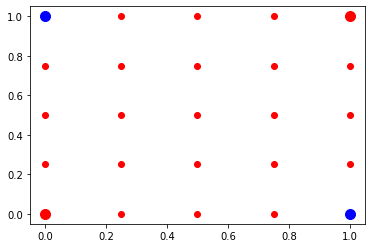

<Figure size 432x288 with 0 Axes>

In [5]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y.tolist()
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs )


#Declaration of argtypes and restypes for the function create_model
my_lib.create_model.argtypes = [c_int]
my_lib.create_model.restype = POINTER(c_float)

#Creation of model
arr_size = 3
native_arr = my_lib.create_model(arr_size)


#Declaration of argtypes and restypes for the function train_rosenblatt_linear_model
arr_type = type(native_arr)
inputs_type = c_float * inputs_len
outputs_type = c_float * expected_len
my_lib.train_rosenblatt_linear_model.argtypes = [arr_type, inputs_type, outputs_type, c_int, c_float, c_int, c_int,c_int]
my_lib.train_rosenblatt_linear_model.restype = None
inputs_native = inputs_type(*dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

#Declaration of argtypes and restypes for the function predict_linear_model_classification
coordonate_type = c_float * 2
my_lib.predict_linear_model_classification.argtypes = [arr_type, coordonate_type, c_int,c_int]
my_lib.predict_linear_model_classification.restype = c_float


#Trainning
r = np.arange(0.0, 1.25, 0.25)

for _ in range(100):
    points_x1_blue = []
    points_x2_blue = []

    points_x1_red = []
    points_x2_red = []

    for i in r:
        for j in r:
            coord = coordonate_type(*[i, j])
            res=my_lib.predict_linear_model_classification(native_arr, coord,arr_size,inputs_len)
            if  res> 0.0:
                points_x1_blue.append(i)
                points_x2_blue.append(j)
            else:
                points_x1_red.append(i)
                points_x2_red.append(j)

    
    if(_%10==0):
        plt.scatter(points_x1_blue, points_x2_blue, c='blue')
        plt.scatter(points_x1_red, points_x2_red, c='red')
        
        plt.scatter([X[p][0] for p in range(len(Y)) if Y[p]>0], [X[p][1] for p in range(len(Y)) if Y[p]>0], c='blue', s=100)
        plt.scatter([X[p][0] for p in range(len(Y)) if Y[p]<0], [X[p][1] for p in range(len(Y)) if Y[p]<0], c='red', s=100)

        plt.show()
        plt.clf()

    dataset_inputs_for_train = []
    for elt in X:
        dataset_inputs_for_train.append(elt[0])
        dataset_inputs_for_train.append(elt[1])

    #update model
    my_lib.train_rosenblatt_linear_model(native_arr, inputs_native, outputs_native, 20, 0.001, arr_size, inputs_len,expected_len)    
    np_arr = np.ctypeslib.as_array(native_arr, (arr_size,))

#Free memory
my_lib.destroy_array.argtypes = [POINTER(c_float), c_int]
my_lib.destroy_array.restype = None
my_lib.destroy_array(native_arr, arr_size)

## MLP

[0.8124943971633911, 0.7908961772918701, 0.7655355930328369, 0.7361314296722412, 0.7025564908981323, 0.6649001836776733, 0.6235162019729614, 0.5790385007858276, 0.5323536396026611, 0.4845293164253235, 0.8354601860046387, 0.8177847862243652, 0.7967954277992249, 0.7721167206764221, 0.7434568405151367, 0.7106696367263794, 0.6738172769546509, 0.6332192420959473, 0.5894726514816284, 0.5434291362762451, 0.8543512225151062, 0.8400207757949829, 0.8228572607040405, 0.80245441198349, 0.7784340977668762, 0.7504949569702148, 0.7184734344482422, 0.6824054718017578, 0.6425778269767761, 0.5995515584945679, 0.8698371648788452, 0.8582980632781982, 0.8443893194198608, 0.8277176022529602, 0.8078793287277222, 0.7844942808151245, 0.7572526931762695, 0.7259745001792908, 0.6906710267066956, 0.6515976190567017, 0.882519006729126, 0.8732731938362122, 0.862075924873352, 0.8485713601112366, 0.8323718309402466, 0.8130767345428467, 0.7903043031692505, 0.7637372016906738, 0.733180046081543, 0.6986209154129028, 0.89

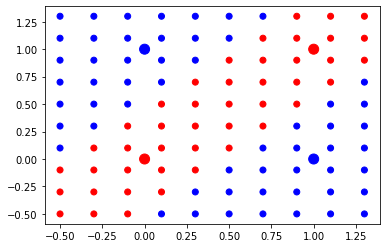

In [27]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])
d=[2,2,1]

#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)


#Declaration of argtypes and restypes for the function create_mlp_model
arr_size = len(d)
arr_type = c_int * arr_size
native_arr = arr_type(*d)
my_lib.create_mlp_model.argtypes = [arr_type, c_int]
my_lib.create_mlp_model.restype = c_void_p


model = my_lib.create_mlp_model(native_arr,arr_size)
test_dataset = [[x1/10, x2 / 10] for x1 in range(-5, 15,2) for x2 in range(-5,15,2)]
colors = ["blue" if output >= 0 else "red" for output in dataset_expected_outputs]


#Declaration of argtypes and restypes for the function predict_mlp_model_classification
p_type = c_float*2
my_lib.predict_mlp_model_classification.argtypes = [c_void_p, p_type,c_int]
my_lib.predict_mlp_model_classification.restype = POINTER(c_float)
p_len =2

predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])


flattened_len=len(flattened_dataset_inputs )
#Declaration of argtypes and restypes for the function predict_mlp_model_classification
inputs_type = c_float * flattened_len
outputs_type = c_float * expected_len
my_lib.train_classification_stochastic_backdrop_mlp_model.argtypes = [c_void_p,inputs_type,outputs_type,c_float,c_int,c_int,c_int]
my_lib.train_classification_stochastic_backdrop_mlp_model.restype = None
inputs_native = inputs_type(*flattened_dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

my_lib.train_classification_stochastic_backdrop_mlp_model(model,inputs_native,outputs_native,0.001,100000,flattened_len,expected_len)


predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])
    
#Free memory
my_lib.destroy_model.argtypes = [c_void_p]
my_lib.destroy_model.restype = None
my_lib.destroy_model(model)

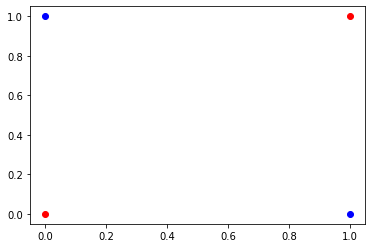

<Figure size 432x288 with 0 Axes>

In [8]:
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4,0], X[2:4,1], color='red')
plt.show()
plt.clf()

























































































### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

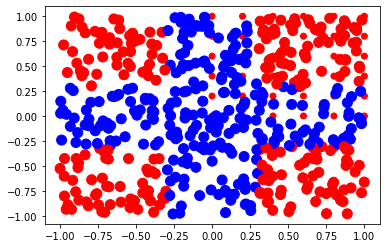

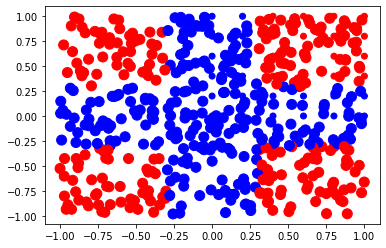

In [4]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X])

d=[2,4,1]

#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)


#Declaration of argtypes and restypes for the function create_mlp_model
arr_size = len(d)
arr_type = c_int * arr_size
native_arr = arr_type(*d)
my_lib.create_mlp_model.argtypes = [arr_type, c_int]
my_lib.create_mlp_model.restype = c_void_p


model = my_lib.create_mlp_model(native_arr,len(d))
test_dataset = [[x1 / 10, x2 / 10] for x1 in range(-10, 20) for x2 in range(-10, 20)]
colors = ["blue" if output >= 0 else "red" for output in dataset_expected_outputs]


#Declaration of argtypes and restypes for the function predict_mlp_model_classification
p_type = c_float*2
my_lib.predict_mlp_model_classification.argtypes = [c_void_p, p_type,c_int]
my_lib.predict_mlp_model_classification.restype = POINTER(c_float)
p_len =2

predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])


flattened_len=len(flattened_dataset_inputs )
#Declaration of argtypes and restypes for the function predict_mlp_model_classification
inputs_type = c_float * flattened_len
outputs_type = c_float * expected_len
my_lib.train_classification_stochastic_backdrop_mlp_model.argtypes = [c_void_p,inputs_type,outputs_type,c_float,c_int,c_int,c_int]
my_lib.train_classification_stochastic_backdrop_mlp_model.restype = None
inputs_native = inputs_type(*flattened_dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

my_lib.train_classification_stochastic_backdrop_mlp_model(model,inputs_native,outputs_native,0.001,10000000,flattened_len,expected_len)


predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),p_len)[0] for p in test_dataset]
predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.show()

flattened_dataset_inputs = []
for p in X:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])
    
#Free memory
my_lib.destroy_model.argtypes = [c_void_p]
my_lib.destroy_model.restype = None
my_lib.destroy_model(model)

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X])

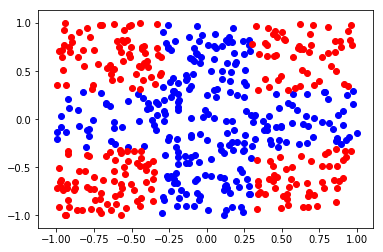

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]] == -1, enumerate(X)))))[:,1], color='red')
plt.show()
plt.clf()

### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else 
              [0, 0, 0]for p in X])

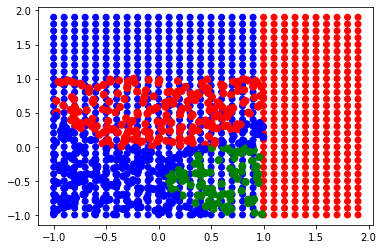

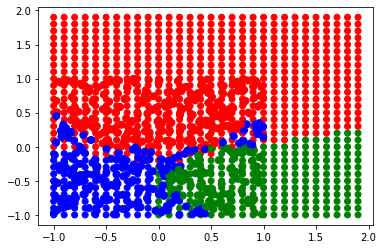

In [72]:
dataset_inputs = np.random.random((500, 2)) * 2.0 - 1.0
dataset_expected_outputs = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else 
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else 
              [0, 0, 0]for p in dataset_inputs])

d = [2, 3]


#Declaration of argtypes and restypes for the function create_mlp_model
arr_size = len(d)
arr_type = c_int * arr_size
native_arr = arr_type(*d)
my_lib.create_mlp_model.argtypes = [arr_type, c_int]
my_lib.create_mlp_model.restype = c_void_p

model = my_lib.create_mlp_model(native_arr,arr_size)
test_dataset = [[x1 / 10, x2 / 10] for x1 in range(-10, 20) for x2 in range(-10, 20)]
colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in dataset_expected_outputs]

p_type = c_float * 2
my_lib.predict_mlp_model_classification.argtypes =[c_void_p,p_type,c_int]
my_lib.predict_mlp_model_classification.restype = POINTER(c_float)

#predicted_outputs = [my_lib.predict_mlp_model_classification(model, p_type(*p),len(p))[0] for p in test_dataset]
predicted_outputs = []
for p in test_dataset:
    prediction = my_lib.predict_mlp_model_classification(model, p_type(*p),len(p))
    prediction = np.ctypeslib.as_array(prediction, (3,))
    predicted_outputs.append(prediction.tolist())

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]

plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in dataset_inputs], [p[1] for p in dataset_inputs], c=colors, s=50)
plt.show()

flattened_dataset_inputs = []
for p in dataset_inputs:
  flattened_dataset_inputs.append(p[0])
  flattened_dataset_inputs.append(p[1])

flattened_dataset_outputs = []
for p in dataset_expected_outputs:
  flattened_dataset_outputs.append(p[0])
  flattened_dataset_outputs.append(p[1])
  flattened_dataset_outputs.append(p[2])

flattened_dataset_input_type = c_float * len(flattened_dataset_inputs)
flattened_dataset_output_type = c_float * len(flattened_dataset_outputs)

my_lib.train_classification_stochastic_backdrop_mlp_model.argtypes = [c_void_p, flattened_dataset_input_type, flattened_dataset_output_type, c_float, c_int, c_int, c_int]
my_lib.train_classification_stochastic_backdrop_mlp_model.restype = None

my_lib.train_classification_stochastic_backdrop_mlp_model(model, flattened_dataset_input_type(*flattened_dataset_inputs), flattened_dataset_output_type(*flattened_dataset_outputs), 0.01, 100000, len(flattened_dataset_inputs), len(flattened_dataset_outputs))

predicted_outputs = []
for p in test_dataset:
    prediction = my_lib.predict_mlp_model_classification(model, p_type(*p),len(p))
    prediction = np.ctypeslib.as_array(prediction, (3,))
    predicted_outputs.append(prediction.tolist())

predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]

plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in dataset_inputs], [p[1] for p in dataset_inputs], c=colors, s=50)
plt.show()

#Free memory
my_lib.destroy_model.argtypes = [c_void_p]
my_lib.destroy_model.restype = None
my_lib.destroy_model(model)

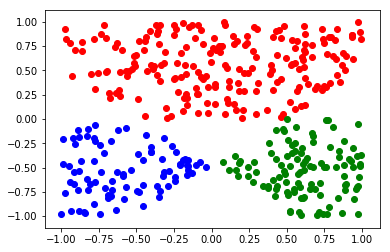

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

### Multi Cross :
        Linear Model x3 : KO
        MLP (2, ?, ?, 3): OK
        
        lloyd?

In [ ]:
X = np.random.random((1000, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25 else [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25 else [0, 0, 1] for p in X])

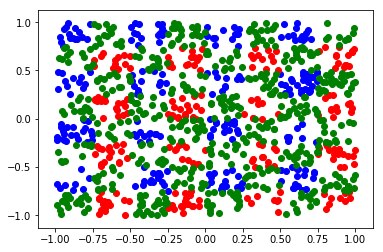

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][0] == 1, enumerate(X)))))[:,1], color='blue')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][1] == 1, enumerate(X)))))[:,1], color='red')
plt.scatter(np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,0], np.array(list(map(lambda elt : elt[1], filter(lambda c: Y[c[0]][2] == 1, enumerate(X)))))[:,1], color='green')
plt.show()
plt.clf()

## Régression

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK

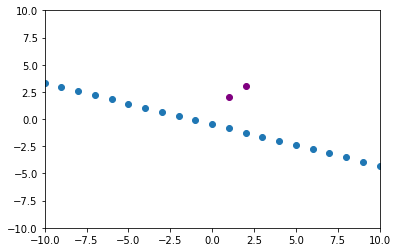

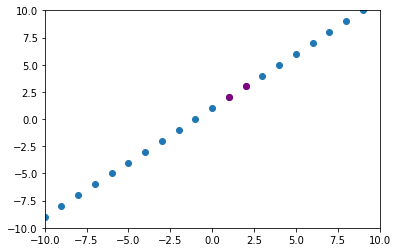

In [45]:
X = np.array([
      [1],
      [2]
])
Y = np.array([
      2,
      3
])

dataset_inputs = toList(X)
dataset_expected_outputs = Y.tolist()

my_lib.create_model.argtypes = [c_int]
my_lib.create_model.restype = POINTER(c_float)

arr_size = 2
native_arr = my_lib.create_model(arr_size)

inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)
arr_type = type(native_arr)
inputs_type = c_float * inputs_len
outputs_type = c_float * expected_len

#Declaration of argtypes and restypes for the function predict_linear_model_classification
coordonate_type = c_float * 1
my_lib.predict_linear_model_regression.argtypes = [arr_type, coordonate_type, c_int,c_int]
my_lib.predict_linear_model_regression.restype = c_float


points_x = []
points_y = []
plt.axis([-10, 10, -10, 10])
for i in range(-10, 11):
    points_x.append(i)
    point=[i]
    coord = coordonate_type(*point)
    points_y.append(my_lib.predict_linear_model_regression(native_arr,coord ,arr_size,inputs_len))

plt.scatter(points_x, points_y)
plt.scatter(dataset_inputs, dataset_expected_outputs, c="purple")
plt.show()

my_lib.train_regression_linear_model.argtypes = [arr_type, inputs_type, outputs_type, c_int, c_int, c_int]
my_lib.train_regression_linear_model.restype =None
inputs_native = inputs_type(*dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

input_dim = arr_size-1
output_dim = arr_size-1
sample_count = inputs_len//input_dim

my_lib.train_regression_linear_model(native_arr, inputs_native, outputs_native, sample_count,input_dim,output_dim)
np_arr = np.ctypeslib.as_array(native_arr, (arr_size,))

points_x = []
points_y = []
plt.axis([-10, 10, -10, 10])
for i in range(-10, 11):
    points_x.append(i)
    point=[i]
    coord = coordonate_type(*point)
    points_y.append(my_lib.predict_linear_model_regression(native_arr,coord ,arr_size,inputs_len))

plt.scatter(points_x, points_y)
plt.scatter(dataset_inputs, dataset_expected_outputs, c="purple")
plt.show()



my_lib.destroy_array.argtypes = [POINTER(c_float), c_int]
my_lib.destroy_array.restype = None
my_lib.destroy_array(native_arr, arr_size)




## MLP

In [ ]:
dataset_inputs = np.array([
      [1],
      [2]
])

dataset_expected_outputs = np.array([
      2,
      3
])

d = [1,1]



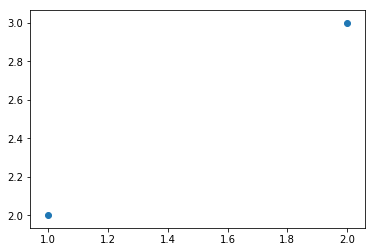

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

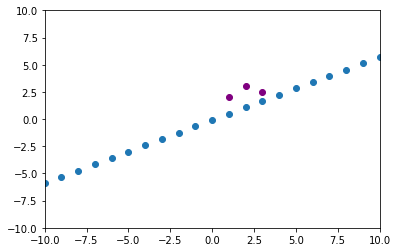

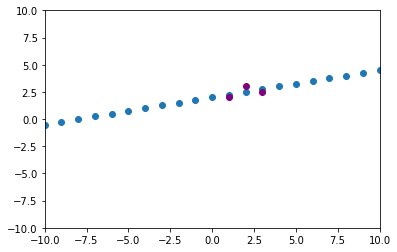

In [29]:
X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])

dataset_inputs = toList(X)
dataset_expected_outputs = Y.tolist()

my_lib.create_model.argtypes = [c_int]
my_lib.create_model.restype = POINTER(c_float)

arr_size = 2
native_arr = my_lib.create_model(arr_size)

inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)
arr_type = type(native_arr)
inputs_type = c_float * inputs_len
outputs_type = c_float * expected_len

#Declaration of argtypes and restypes for the function predict_linear_model_classification
coordonate_type = c_float * 1
my_lib.predict_linear_model_regression.argtypes = [arr_type, coordonate_type, c_int,c_int]
my_lib.predict_linear_model_regression.restype = c_float


points_x = []
points_y = []
plt.axis([-10, 10, -10, 10])
for i in range(-10, 11):
    points_x.append(i)
    point=[i]
    coord = coordonate_type(*point)
    points_y.append(my_lib.predict_linear_model_regression(native_arr,coord ,arr_size,inputs_len))

plt.scatter(points_x, points_y)
plt.scatter(dataset_inputs, dataset_expected_outputs, c="purple")
plt.show()

my_lib.train_regression_linear_model.argtypes = [arr_type, inputs_type, outputs_type, c_int, c_int, c_int]
my_lib.train_regression_linear_model.restype =None
inputs_native = inputs_type(*dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

input_dim = arr_size-1
output_dim = arr_size-1
sample_count = inputs_len//input_dim

my_lib.train_regression_linear_model(native_arr, inputs_native, outputs_native, sample_count,input_dim,output_dim)
np_arr = np.ctypeslib.as_array(native_arr, (arr_size,))

points_x = []
points_y = []
plt.axis([-10, 10, -10, 10])
for i in range(-10, 11):
    points_x.append(i)
    point=[i]
    coord = coordonate_type(*point)
    points_y.append(my_lib.predict_linear_model_regression(native_arr,coord ,arr_size,inputs_len))

plt.scatter(points_x, points_y)
plt.scatter(dataset_inputs, dataset_expected_outputs, c="purple")
plt.show()



my_lib.destroy_array.argtypes = [POINTER(c_float), c_int]
my_lib.destroy_array.restype = None
my_lib.destroy_array(native_arr, arr_size)




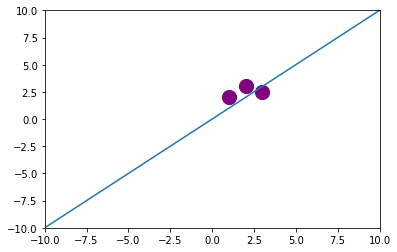

In [93]:
X = np.array([
      [1],
      [2],
      [3]
])
Y = np.array([
      2,
      3,
      2.5
])

d=[1,3,1]

#Convert array to list
dataset_inputs  = toList(X)
dataset_expected_outputs  = Y.tolist()
inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)

#Declaration of argtypes and restypes for the function create_mlp_model
arr_size = len(d)
arr_type = c_int * arr_size
native_arr = arr_type(*d)
my_lib.create_mlp_model.argtypes = [arr_type, c_int]
my_lib.create_mlp_model.restype = c_void_p

#creation of the model
model = my_lib.create_mlp_model(native_arr,1)
test_dataset_inputs = [i for i in range(-10, 11)]

#declaration of the predict
f = c_float * 1
my_lib.predict_mlp_model_regression.argtypes = [c_void_p, f,c_int]
my_lib.predict_mlp_model_regression.restype = POINTER(c_float)
coordinate_len =1

#get the predicted outputs without training
predicted_outputs = [my_lib.predict_mlp_model_regression(model, f(*[point]), 1)[0] for point in test_dataset_inputs]

#plot the result
plt.plot(test_dataset_inputs, predicted_outputs)
plt.scatter([p for p in dataset_inputs], dataset_expected_outputs, s=200, color='purple')
plt.axis([-10, 10, -10, 10])
plt.show()

my_lib.destroy_model.argtypes = [c_void_p]
my_lib.destroy_model.restype = None
my_lib.destroy_model(model)

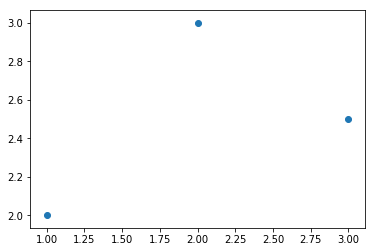

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(X,Y)
plt.show()
plt.clf()

### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

In [ ]:
X = np.array([
      [1, 1],
      [2, 2],
      [3, 1]
])
Y = np.array([
      2,
      3,
      2.5
])

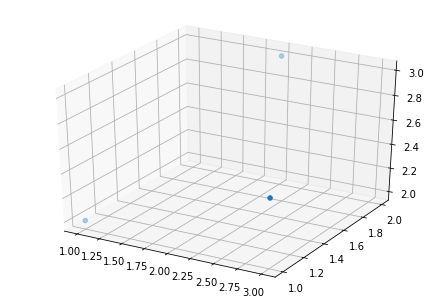

<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

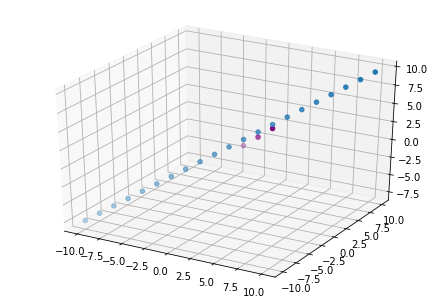

<Figure size 432x288 with 0 Axes>

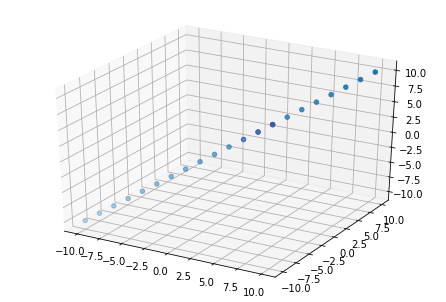

<Figure size 432x288 with 0 Axes>

In [43]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

X = np.array([
      [1,1],
      [2,2],
      [3,3]
])
Y = np.array([
      1,
      2,
      3
])

ax.scatter(X[:,0],X[:,1],Y,c='purple')

dataset_inputs = [j[0] for j in X]
dataset_expected_outputs = Y.tolist()

my_lib.create_model.argtypes = [c_int]
my_lib.create_model.restype = POINTER(c_float)

arr_size = 2
native_arr = my_lib.create_model(2)

inputs_len = len(dataset_inputs)
expected_len = len(dataset_expected_outputs)
arr_type = type(native_arr)
inputs_type = c_float * inputs_len
outputs_type = c_float * expected_len

#Declaration of argtypes and restypes for the function predict_linear_model_classification
coordonate_type = c_float * 1
my_lib.predict_linear_model_regression.argtypes = [arr_type, coordonate_type, c_int,c_int]
my_lib.predict_linear_model_regression.restype = c_float


points_x = []
points_y = []

for i in range(-10, 11):
    points_x.append(i)
    point=[i]
    coord = coordonate_type(*point)
    points_y.append(my_lib.predict_linear_model_regression(native_arr,coord ,arr_size,inputs_len))


ax.scatter(points_x,points_x,points_y)
plt.show()
plt.clf()

my_lib.train_regression_linear_model.argtypes = [arr_type, inputs_type, outputs_type, c_int, c_int, c_int]
my_lib.train_regression_linear_model.restype =None
inputs_native = inputs_type(*dataset_inputs)
outputs_native = outputs_type(*dataset_expected_outputs)

input_dim = arr_size-1
output_dim = arr_size-1
sample_count = inputs_len//input_dim

my_lib.train_regression_linear_model(native_arr, inputs_native, outputs_native, sample_count,input_dim,output_dim)
np_arr = np.ctypeslib.as_array(native_arr, (arr_size,))


fig = plt.figure()
ax2 = Axes3D(fig)
ax2.scatter(X[:,0],X[:,1],Y,c='purple')
points_x = []
points_y = []
for i in range(-10, 11):
    points_x.append(i)
    point=[i]
    coord = coordonate_type(*point)
    points_y.append(my_lib.predict_linear_model_regression(native_arr,coord ,arr_size,inputs_len))

ax2.scatter(points_x,points_x,points_y)
plt.show()
plt.clf()



my_lib.destroy_array.argtypes = [POINTER(c_float), c_int]
my_lib.destroy_array.restype = None
my_lib.destroy_array(native_arr, arr_size)

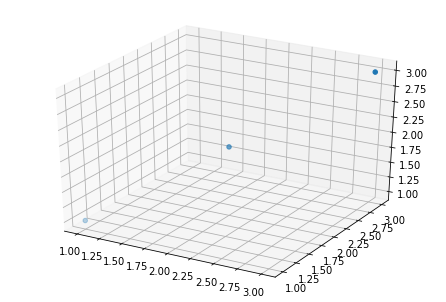

<Figure size 432x288 with 0 Axes>

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()

### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

In [ ]:
X = np.array([
      [1, 0],
      [0, 1],
      [1, 1],
      [0, 0],
])
Y = np.array([
      2,
      1,
      -2,
      -1
])

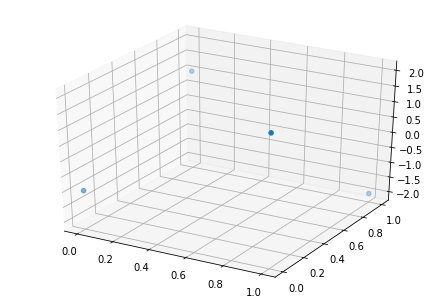

<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1],Y)
plt.show()
plt.clf()